# Основные цели и задачи проекта.


Основные цели EDA:

1. Сформулировать предположения и гипотезы для дальнейшего построения модели.
2. Проверить качество данных и очистить их, если это необходимо.
3. Определиться с параметрами модели.

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Задача - с помощью разведывательного анализа данных определить параметры модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

Основные этапы:

1. Посмотреть на данные.
2. Проверить данные на пустые значения.
3. Проверить данные на дублированные/полностью скоррелированные значения.
4. Проверить данные на наличие выбросов.
5. Отобрать данные, пригодные для дальнейшего построения модели.

In [ ]:
#Импортируем необходимые библиотеки и модули. Подгружаем датафрейм с данными.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_math = pd.read_csv('C:\Program Files/stud_math.xls')

In [13]:
#Предобработка. Здесь будут находиться функции для работы со столбцами, используемые многократно для упрощения работы.

#1. Функция для определения границ выбросов, принимающая на вход конкретный столбец датафрейма.

def outliers (x):
    
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f = perc25 - 1.5*IQR, l = perc75 + 1.5 * IQR))
    x.loc[x.between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)].hist(bins = 15, range = (10, 30),label = 'IQR')
    
    plt.legend();
    
#2. Функция для определения границ выбросов, принимающая на вход конкретный столбец датафрейма, 
#но с с другими настройками рэнджа с целью отображения данных. Данные, значение которых не может опускаться ниже нуля, 
#но может быть относительно близко к ним.

def outliers_two (x):
    
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f = perc25 - 1.5*IQR, l = perc75 + 1.5 * IQR))
    x.loc[x.between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)].hist(bins = 15, range = (0, 10),label = 'IQR')
   
    plt.legend();

#3. Та же функция, что и выше, но с другими настройками рэнджа и с проверкой на "здравый смысл", 
#так как значения не могут быть выше "100"  
    
def outliers_three (x):
    
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f = perc25 - 1.5*IQR, l = perc75 + 1.5 * IQR))
    x.loc[x.between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)].hist(bins = 15, range = (0, 100),label = 'IQR')
    
    x.loc[x <= 100].hist(alpha = 0.5, bins = 15, range = (0, 100), label = 'Здравый смысл')
    plt.legend();
    
#4. Функция определения уникальных значений столбца.

def uniq_values (y):
    display(pd.DataFrame(y.value_counts()))
    print("Значений, встретившихся в столбце более 10 раз:", (y.value_counts()>10).sum())
    print("Уникальных значений:", y.nunique())
    
#5. Функция замены пропущенных значений в столбцах.

def del_nan (x):

    x = x.apply(lambda x: None if pd.isnull(x) else None if x == 'NaN' 
                      else x)
    
    
    
#6. Функция формирования боксплотов для номинативных переменных.
    
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = column, y = 'score', 
                data = stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].value_counts().index[:5])],
               ax = ax)
    plt.xticks(rotation = 45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
#7. Функция определения столбца со статистически значимыми различиями.
    
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05 / len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


In [14]:
#Произведем первичный осмотр данных на примере 10 верхних строк датафрейма.

display(stud_math.head(10))

#Получим информацию о типах данных и заполненности столбцов датафрейма.

stud_math.info()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [15]:
#Для собственного удобства обращения со столбцами отредактируем некоторые наименования столбцов.

stud_math.rename(columns = {'Pstatus':'pstatus', 'Medu':'medu', 'Fedu':'fedu', 'Mjob':'mjob','Fjob':'fjob', 'studytime, granular':'studytime_granular'}, inplace = True)

Исходя из описания столбцов можно сделать вывод, что всего восемь столбцов - age, failures, absences, score, medu,fedu, studytime, goout.
Остальные - так или иначе номинативные, так как представляют собой либо строковые величины, либо числовые категории, не представляющие собой интереса как числа.



In [16]:
#Также один из столбцов - studytime, granular - от него мы избавимся.

stud_math.drop('studytime_granular', axis = 1, inplace = True)

In [17]:
##Распределение по возрасту

#"Выбросы" из распределения по возрасту извлекаться не будут, так как это отдельная категория учеников
#которые могут стать источником получения дополнительной полезной информации, а не случайное отклонившееся наблюдение.


count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

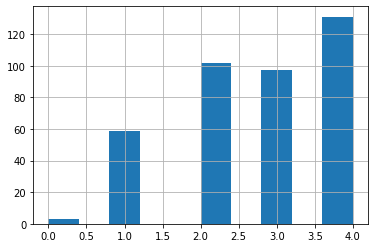

In [18]:
##Распределение по образованию матери

stud_math.medu.hist()
stud_math.medu.describe()

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

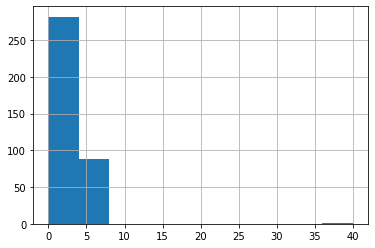

In [19]:
##Распределение по образованию отца

stud_math.fedu.hist()
stud_math.fedu.describe()

In [20]:
#Гистрограмма распределения образования отца демонстрирует наблюдение-выброс, 
#который, по всей видимости, связан с неверным занесением информации, а именно: одно из значений равняется 40.0 
#при допустимом максимуме в 4.0.

stud_math[stud_math['fedu'] == 40]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [21]:
#Будем считать это ошибкой ввода данных и исправим на 4.0.

stud_math.fedu.loc[11] = 4.0

C:\Users\79054\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

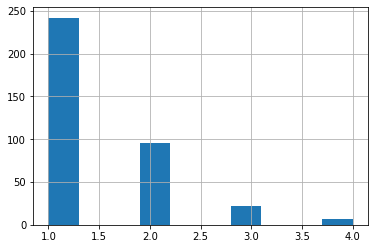

In [22]:
##Распределение по времени в пути до школы

stud_math.traveltime.hist()
stud_math.traveltime.describe()

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

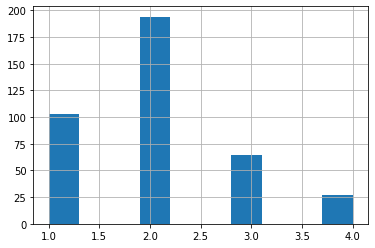

In [23]:
##Распределение по времени на учёбу помимо школы в неделю

stud_math.studytime.hist()
stud_math.studytime.describe()

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

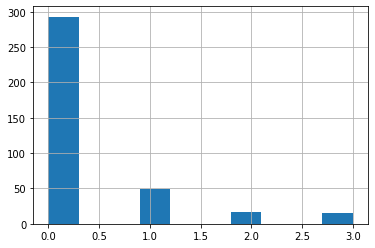

In [24]:
##Распределение по количеству внеучебных неудач

stud_math.failures.hist()
stud_math.failures.describe()


count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

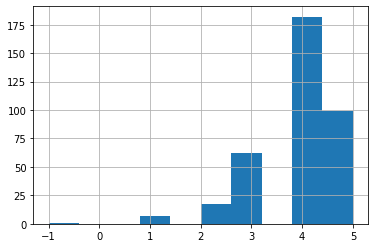

In [25]:
##Распределение по семейным отношениям

stud_math.famrel.hist()
stud_math.famrel.describe()


In [26]:
#Так же, как и с образованием отцов немногим выше, предположим ошибку при вводе данных - значение "-1".

stud_math[stud_math['famrel'] == -1]


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


In [27]:
#Будем считать это ошибкой ввода данных и исправим на 1.0.

stud_math.famrel.loc[25] = 1.0

C:\Users\79054\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

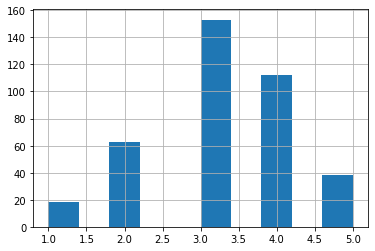

In [28]:
##Распределение по свободному времени после школы

stud_math.freetime.hist()
stud_math.freetime.describe()

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

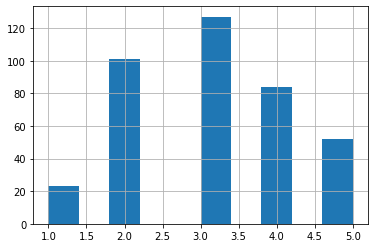

In [29]:
##Распределение по проведенному времени с друзьями

stud_math.goout.hist()
stud_math.goout.describe()

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

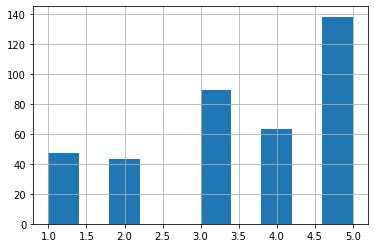

In [30]:
##Распределение по текущему состоянию здоровья

stud_math.health.hist()
stud_math.health.describe()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

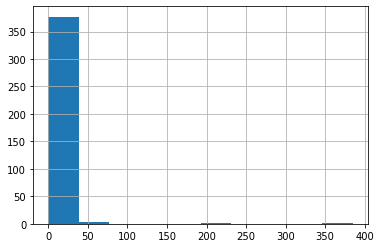

In [31]:
##Распределение по количеству пропущенных занятий

stud_math.absences.hist()
stud_math.absences.describe()

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

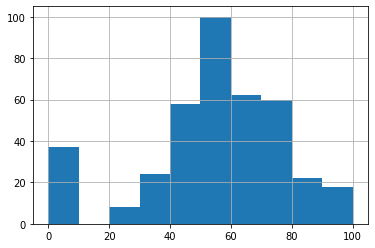

In [32]:
##Распределение по баллам за госэкзамен по математике

stud_math.score.hist()
stud_math.score.describe()


# Перейдем к рассмотрению числовых переменных и устранению выбросов.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


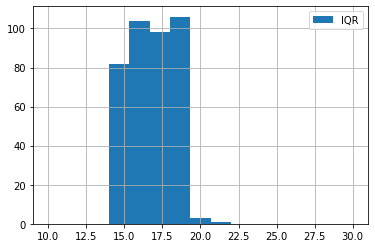

In [33]:
#Далее перейдем к рассмотрению тех количественных переменных, 
#которые могут содержать выбросы исходя из просмотра гистограмм распределения признака:

outliers(stud_math.age)


25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


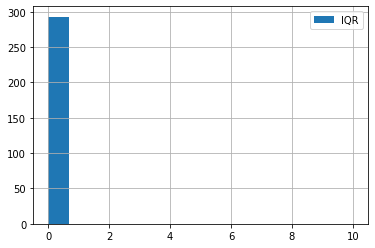

In [34]:
outliers_two(stud_math.failures)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


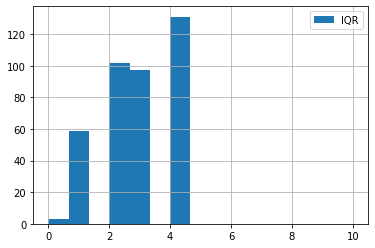

In [35]:
outliers_two(stud_math.medu)

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


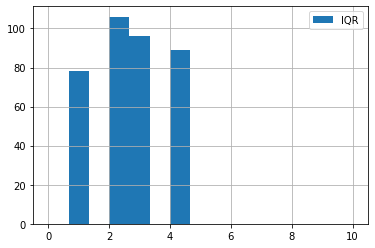

In [36]:
outliers_two(stud_math.fedu)

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


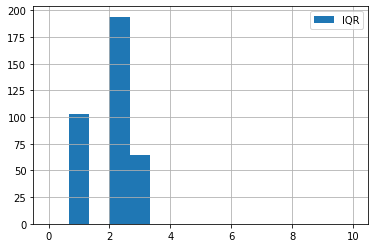

In [37]:
outliers_two(stud_math.studytime)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


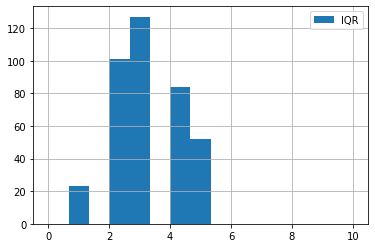

In [38]:
outliers_two(stud_math.goout)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


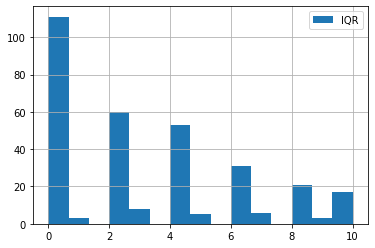

In [39]:
outliers_two(stud_math.absences)

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


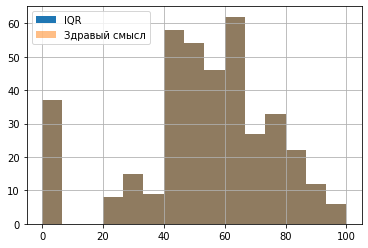

In [40]:
#Фильтр выбросов для распределения баллов за госэкзамен сделаем с проверкой на "здравый смысл".
#Количество баллов не может быть выше "100".

outliers_three(stud_math.score)

# Теперь перейдем к рассмотрению номинативных переменных на предмет уникальных значений и заменим пропущенные значения.

In [41]:
del_nan(stud_math.school)
uniq_values(stud_math.school)

,school
GP,349
MS,46


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [42]:
del_nan(stud_math.sex)
uniq_values(stud_math.sex)

,sex
F,208
M,187


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [43]:
del_nan(stud_math.address)
uniq_values(stud_math.address)

,address
U,295
R,83


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [44]:
del_nan(stud_math.famsize)
uniq_values(stud_math.famsize)

,famsize
GT3,261
LE3,107


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [45]:
del_nan(stud_math.mjob)
uniq_values(stud_math.mjob)

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5


In [46]:
del_nan(stud_math.fjob)
uniq_values(stud_math.fjob)

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5


In [47]:
del_nan(stud_math.guardian)
uniq_values(stud_math.guardian)

,guardian
mother,250
father,86
other,28


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3


In [48]:
del_nan(stud_math.traveltime)
uniq_values(stud_math.traveltime)

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 4


In [49]:
del_nan(stud_math.schoolsup)
uniq_values(stud_math.schoolsup)

,schoolsup
no,335
yes,51


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [50]:
del_nan(stud_math.famsup)
uniq_values(stud_math.famsup)

,famsup
yes,219
no,137


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [51]:
del_nan(stud_math.paid)
uniq_values(stud_math.paid)

,paid
no,200
yes,155


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [52]:
del_nan(stud_math.activities)
uniq_values(stud_math.activities)

,activities
yes,195
no,186


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [53]:
del_nan(stud_math.nursery)
uniq_values(stud_math.nursery)

,nursery
yes,300
no,79


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [54]:
del_nan(stud_math.higher)
uniq_values(stud_math.higher)

,higher
yes,356
no,19


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [55]:
del_nan(stud_math.romantic)
uniq_values(stud_math.romantic)

,romantic
no,240
yes,124


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [56]:
del_nan(stud_math.internet)
uniq_values(stud_math.internet)

,internet
yes,305
no,56


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


In [57]:
del_nan(stud_math.famrel)
uniq_values(stud_math.famrel)

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,8


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 5


In [58]:
del_nan(stud_math.freetime)
uniq_values(stud_math.freetime)

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5


In [59]:
del_nan(stud_math.health)
uniq_values(stud_math.health)

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5


In [60]:
del_nan(stud_math.reason)
uniq_values(stud_math.reason)

,reason
course,137
home,104
reputation,103
other,34


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4


In [61]:
del_nan(stud_math.pstatus)
uniq_values(stud_math.pstatus)

,pstatus
T,314
A,36


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2


# Проведем корреляционный анализ и выясним, какие переменные коррелируют с итоговой оценкой по госэкзамену по математике.

In [62]:
#Применим матрицу корреляции только для числовых переменных:

stud_math.corr().loc[['age', 'failures', 'absences','medu','fedu','goout', 'studytime', 'goout', 'score']][['age', 'failures', 'absences','medu','fedu','goout', 'studytime', 'goout', 'score']]

,age,failures,absences,medu,fedu,goout,studytime,goout,score
age,1.000000,0.228047,0.093592,-0.161704,-0.163670,0.135107,-0.015556,0.135107,-0.155726
failures,0.228047,1.000000,0.057391,-0.245463,-0.272882,0.120914,-0.178992,0.120914,-0.344338
absences,0.093592,0.057391,1.000000,-0.011944,0.022572,-0.048738,-0.026544,-0.048738,0.065283
medu,-0.161704,-0.245463,-0.011944,1.000000,0.625516,0.064164,0.078589,0.064164,0.213349
fedu,-0.163670,-0.272882,0.022572,0.625516,1.000000,0.042663,0.012896,0.042663,0.130923
goout,0.135107,0.120914,-0.048738,0.064164,0.042663,1.000000,-0.051280,1.000000,-0.129685
studytime,-0.015556,-0.178992,-0.026544,0.078589,0.012896,-0.051280,1.000000,-0.051280,0.115741
goout,0.135107,0.120914,-0.048738,0.064164,0.042663,1.000000,-0.051280,1.000000,-0.129685
score,-0.155726,-0.344338,0.065283,0.213349,0.130923,-0.129685,0.115741,-0.129685,1.000000


По результатам мы видим, что наиболее скоррелированы с колонкой score все столбцы, кроме absences.
Особенно сильная корреляция с колонками - failures, medu, age, fedu, goout - коэффициент более 0.1 по модулю. Их предполагается использовать для будущей модели.

Наименее скоррелирован столбец absences.

In [63]:
#Избавимся от него.

stud_math.drop('absences', axis = 1, inplace = True) #Избавляемся от слабоскоррелированного числового столбца.

# Проанализируем номинативные переменные и устраним те, которые не влияют на колонку score.

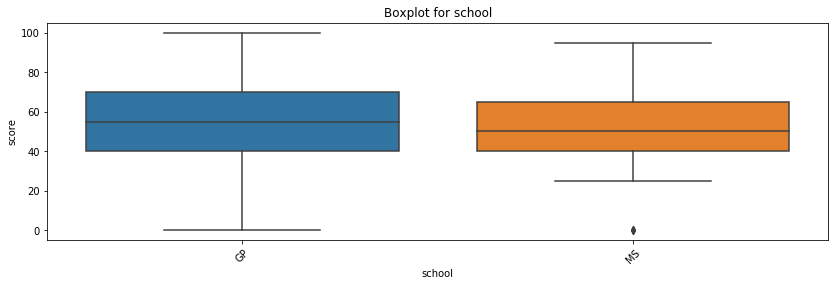

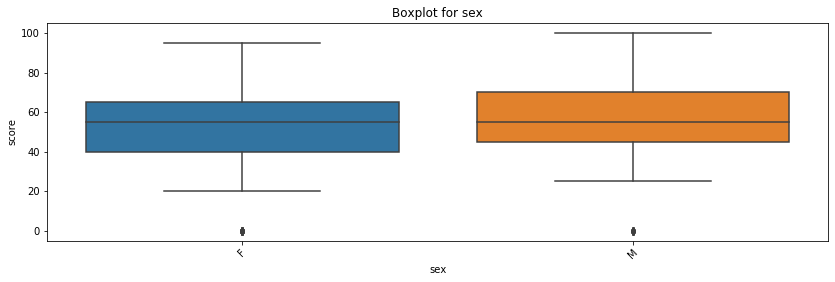

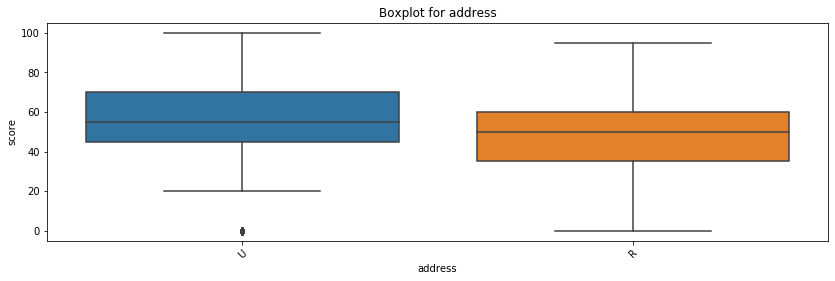

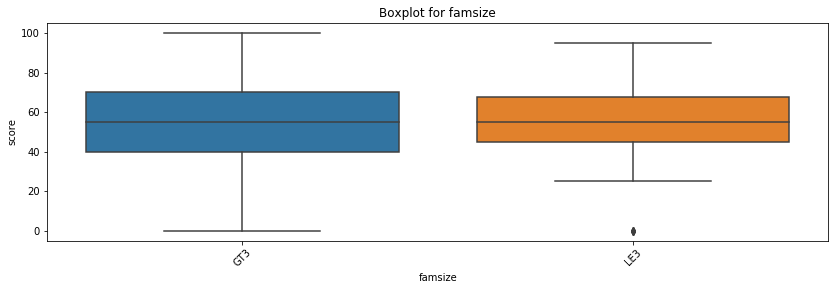

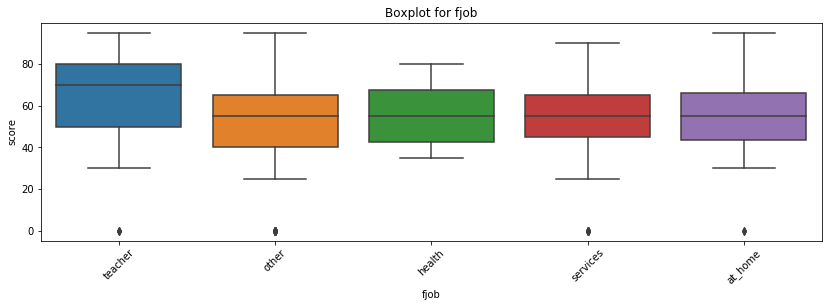

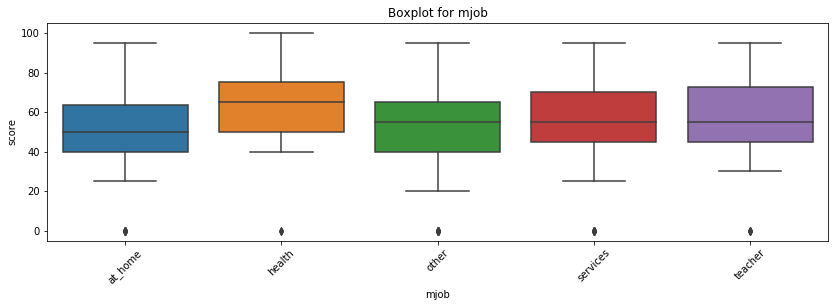

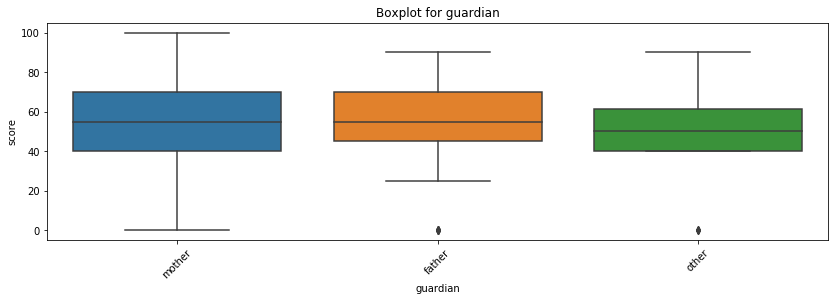

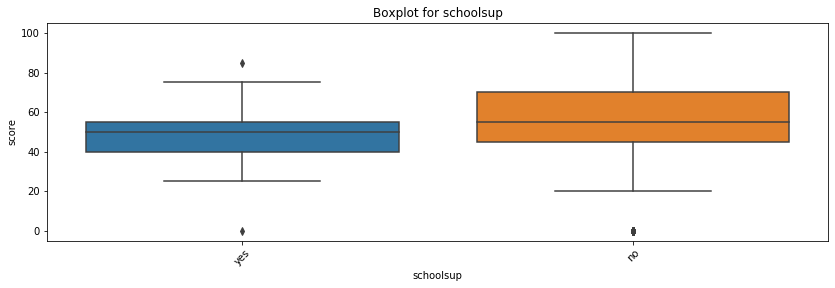

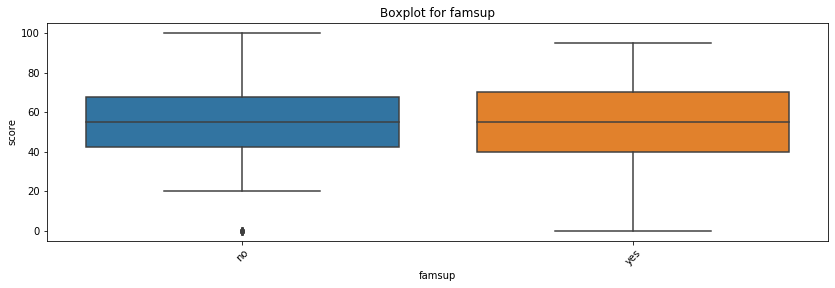

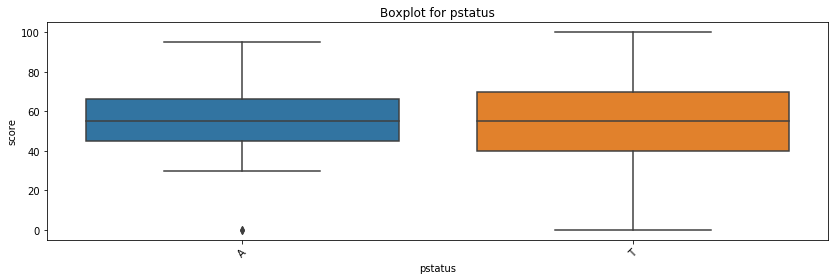

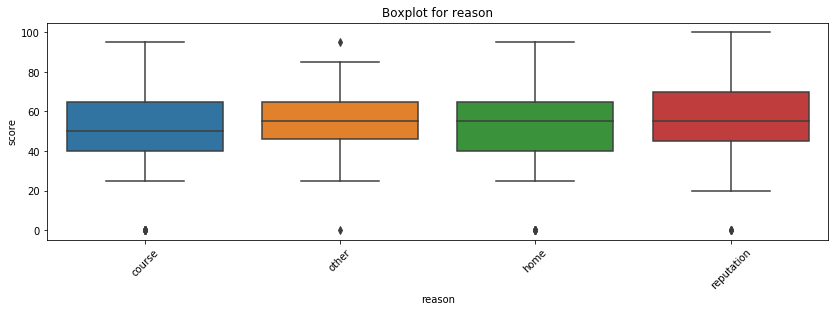

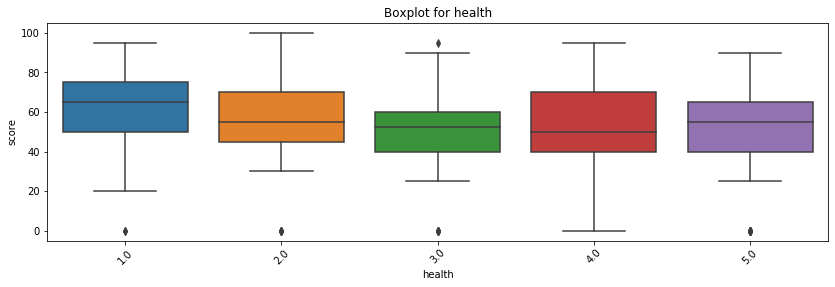

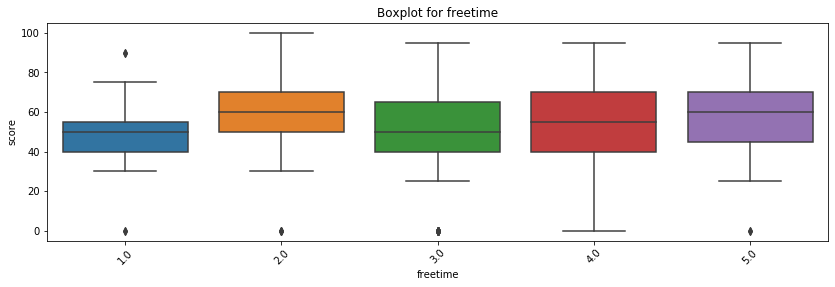

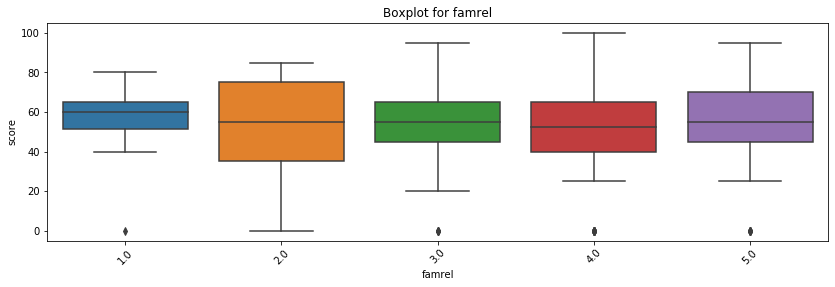

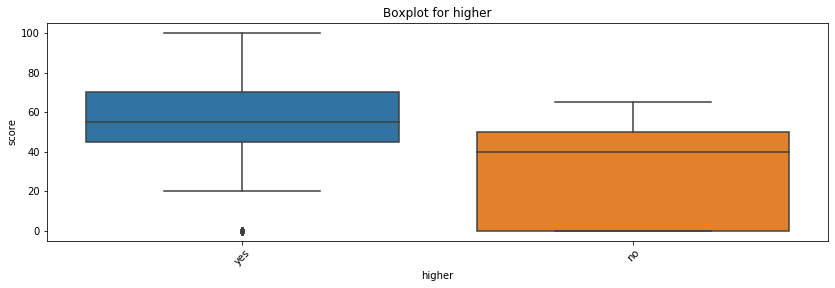

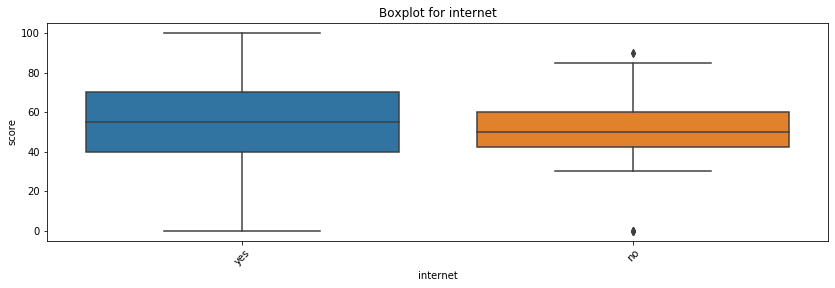

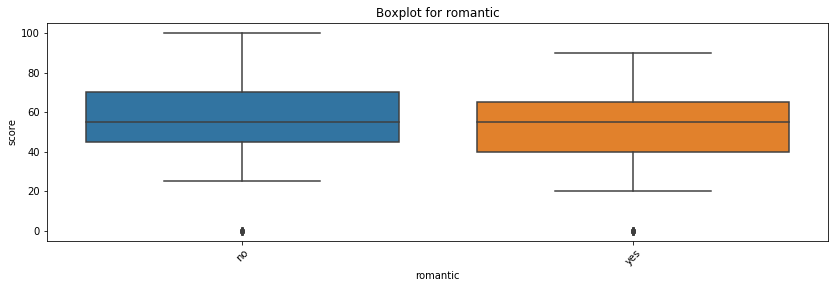

In [64]:
for col in ['school', 'sex', 'address', 'famsize', 'fjob','mjob','guardian','schoolsup','famsup','pstatus','reason','health','freetime','famrel','higher','internet','romantic']:
    get_boxplot(col)

Исходя из графиков видно, что влиять на результат по госэкзамену могут следующие категориальные переменные - mjob, schoolsup, health, freetime, higher.

Интересно, что судя боксплотам работа отца имеет меньшее значение, чем работа матери.

# Проверим статистическую разницу в распределении оценок по номинативным признакам с помощью теста Стьюдента.

In [65]:
for col in ['school', 'sex', 'address', 'famsize', 'fjob', 'mjob', 'guardian', 'schoolsup', 'famsup', 'pstatus', 'reason', 'health', 'freetime', 'famrel', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки mjob


C:\Users\79054\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\79054\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\79054\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


В соответствии с тестом Стьюдента статическую значимость для дальнейшего построения модели имеет только столбец с работой матери.

In [66]:
#Избавимся от остальных номинавтивных столбцов.

stud_math.drop(['school', 'sex', 'address', 'famsize', 'fjob', 'guardian', 'schoolsup', 'famsup', 'pstatus', 'reason', 'health', 'freetime', 'famrel', 'higher', 'internet', 'romantic'], axis = 1, inplace = True)

# Ниже представлены оставшиеся данные.

In [67]:
stud_math.head()

,age,medu,fedu,mjob,traveltime,studytime,failures,paid,activities,nursery,goout,score
0,18,4.0,4.0,at_home,2.0,2.0,0.0,no,no,yes,4.0,30.0
1,17,1.0,1.0,at_home,1.0,2.0,0.0,no,no,no,3.0,30.0
2,15,1.0,1.0,at_home,1.0,2.0,3.0,NaN,no,yes,2.0,50.0
3,15,4.0,2.0,health,1.0,3.0,0.0,yes,yes,yes,2.0,75.0
4,16,3.0,3.0,other,1.0,2.0,0.0,yes,no,yes,2.0,50.0


# Выводы

- Практически столбцы, кроме age, sex и school, имеются пустыв значения, которые были заменены на NaN;
- Столбец studytime, granular был практически сразу исключен, так как не содержался в описании к датафрейму;
- Столбцы fedu и famrel содержали ошибки. Эти ошибки были отнесены к некачественному сбору данных и заменены на имевшиеся в виду корректные данные. 
- Интересным фактом является то, что такие переменные, как пропущенные занятия, состояние здоровья, количество свободного времени, желание получить высшее образование - практически не влияют на итоговую оценку госэкзамена по математике.
- Статическую значимость для дальнейшего построения модели имеет только столбец с работой матери, а работа отца - нет.
- Построение модели предполагается осуществлять с использованием следующих переменных: age, medu, fedu, mjob, traveltime, studytime, failures, paid, activities, nursery, goout, score.